In [1]:
import sys
import joblib
import numpy as np
import matplotlib as mpl
mpl.rc("savefig", dpi=600)

from matplotlib import pyplot as plt
import matplotlib.patches as patches

sys.path.append('../..')
%matplotlib inline

In [2]:
RES_FNAME = '../saved_data/cond_time_results.pkl'
N_SAMPLES = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
DIM = [8, 16, 32, 64, 128, 256, 512, 1024]
results = joblib.load(RES_FNAME)
res_mats = {}
for method in ['chsic', 'kcit', 'kcipt', 'nn', 'rcit']:
    res_mats[method] = np.zeros((len(N_SAMPLES), len(DIM)))
    for row_id, n_samples in enumerate(N_SAMPLES):
        for col_id, dim in enumerate(DIM):
            try:
                reslist = np.array(results[method + '_{}_{}'.format(n_samples, dim)])                    
                if np.sum(reslist == -1) > 0 or np.mean(reslist[:, 2]) > 31:
                    # Out of time.
                    res_mats[method][col_id, row_id] = 0
                elif np.sum(reslist == -2) > 0:
                    # Matlab error.
                    res_mats[method][col_id, row_id] = -2
                elif np.sum(reslist[:, 0] > .05) > 5:
                    # Too many Type I errors.
                    res_mats[method][col_id, row_id] = -1
                elif np.sum(reslist[:, 1] < .05) > 5:
                    # Too many Type II errors.
                    res_mats[method][col_id, row_id] = -1
                else:
                    res_mats[method][col_id, row_id] = 1
            except KeyError:
                pass
    #res_mats[method][res_mats[method] == -2] = np.nan
    res_mats[method] = res_mats[method].T

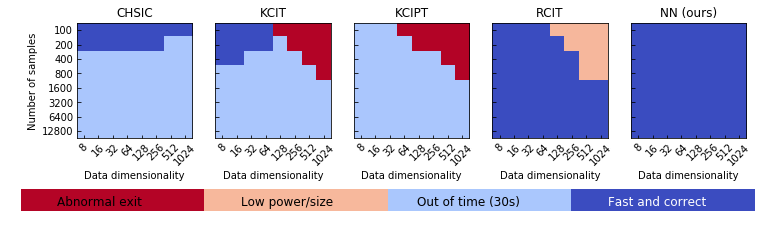

In [3]:
fig = plt.figure(figsize=(12, 3), facecolor='white', dpi=600)
cmap = plt.get_cmap('coolwarm_r')
cmap.set_bad('black',1.)
cmap.set_under('white', 1.)

ax = plt.subplot(1, 5, 1)
plt.title('CHSIC')
plt.xlabel('Data dimensionality')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], DIM, rotation=45)
plt.ylabel('Number of samples')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], N_SAMPLES)
ax.tick_params(direction='in')
plt.imshow(res_mats['chsic'], vmin=-2, vmax=1, cmap=cmap)

ax = plt.subplot(1, 5, 2)
plt.title('KCIT')
plt.xlabel('Data dimensionality')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], DIM, rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], [])
ax.tick_params(direction='in')
plt.imshow(res_mats['kcit'], vmin=-2, vmax=1, cmap=cmap)

ax = plt.subplot(1, 5, 3)
plt.title('KCIPT')
plt.xlabel('Data dimensionality')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], DIM, rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], [])
ax.tick_params(direction='in')
plt.imshow(res_mats['kcipt'], vmin=-2, vmax=1, cmap=cmap)

ax = plt.subplot(1, 5, 4)
plt.title('RCIT')
plt.xlabel('Data dimensionality')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], DIM, rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], [])
ax.tick_params(direction='in')
plt.imshow(res_mats['rcit'], vmin=-2, vmax=1, cmap=cmap)

ax = plt.subplot(1, 5, 5)
plt.title('NN (ours)')
plt.xlabel('Data dimensionality')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], DIM, rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], [])
ax.tick_params(direction='in')
plt.imshow(res_mats['nn'], vmin=-2, vmax=1, cmap=cmap)

ax = fig.add_axes([0.06, -.1, .85, .1])
plt.axis('off')
ax.add_patch(
    patches.Rectangle((0, 0), .25, 1, facecolor=cmap(0))
)
plt.text(0.05, 0.25, 'Abnormal exit', fontsize=12)

ax.add_patch(
    patches.Rectangle((.25, 0), .25, 1, facecolor=cmap(1/3.))
)
plt.text(0.3, 0.25, 'Low power/size', fontsize=12)

ax.add_patch(
    patches.Rectangle((.5, 0), .25, 1, facecolor=cmap(2/3.))
)
plt.text(0.54, 0.25, 'Out of time (30s)', fontsize=12)

ax.add_patch(
    patches.Rectangle((.75, 0), .25, 1, facecolor=cmap(1.))
)
plt.text(0.8, 0.25, 'Fast and correct', fontsize=12, color='white')

In [ ]:
from independence_test.experiment_settings import SAMPLE_NUMS, DSETS
from independence_test.utils import pc_ks
DSET_NAME = 'chaos'
RES_FNAME = '../saved_data/{}_results.pkl'.format(DSET_NAME)
res = joblib.load(RES_FNAME)
res_mats = {}
for method in ['chsic', 'kcit', 'nn', 'rcit', 'kcipt']:
    for key in res.keys():
        pval_d = np.array(res[key])[:, 0]
        pval_i = np.array(res[key])[:, 1]
        res_mats[key] = (pc_ks(pval_d)[0], pc_ks(pval_i)[1], np.median(pval_i), 1-pc_ks(pval_i)[0])

In [ ]:
proc_res = {}
GAMMA = DSETS[DSET_NAME][1]
for method in ['chsic', 'kcit', 'kcipt', 'nn', 'rcit']:
    proc_res[method] = {}
    proc_res[method]['auc'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method]['ks'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method]['ksauc'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))

    for row_id, n_samples in enumerate(SAMPLE_NUMS):
        for col_id, gamma in enumerate(GAMMA):
            res = res_mats[method + '_chaos_30mt_' + str(n_samples) + 'samples_1dim_' + str(gamma) + 'complexity']
            proc_res[method]['auc'][row_id, col_id] = res[0]
            proc_res[method]['ks'][row_id, col_id] = res[1]
            proc_res[method]['ksauc'][row_id, col_id] = res[2]
    #res_mats[method][res_mats[method] == -2] = np.nan


In [ ]:
# Make x-labels
ticklabels = []
for n_samples in SAMPLE_NUMS:
    for gamma in GAMMA:
        ticklabels.append('ns={}, g={}'.format(n_samples, gamma))

plt.figure(figsize=(9*1.5, 2*1.5), facecolor='white', dpi=600)
plt.subplot(1,3,1)
plt.title('Dependent chaos data')
plt.ylim([-.01,1.1])
plt.plot(proc_res['kcit']['auc'].flatten(), 'o', label='kcit')
plt.plot(proc_res['rcit']['auc'].flatten(), 'o', label='rcit')
plt.plot(proc_res['chsic']['auc'].flatten(), 'o', label='chsic')
plt.plot(proc_res['nn']['auc'].flatten(), 'kx', label='nn', markersize=10)
plt.yticks([0, .5, 1])
plt.xticks(range(len(ticklabels)), ticklabels, rotation=90)
plt.ylabel('AUC')
plt.grid('on')
plt.legend()

plt.subplot(1,3,2)
plt.ylim([1e-20,1.1])
plt.axhline(.05)
#plt.yscale('log')
TYPE = 'ksauc'
plt.title('Independent chaos data')
plt.plot(proc_res['kcit'][TYPE].flatten(), 'o', label='kcit')
plt.plot(proc_res['rcit'][TYPE].flatten(), 'o', label='rcit')
plt.plot(proc_res['chsic'][TYPE].flatten(), 'o', label='chsic')
plt.plot(proc_res['nn'][TYPE].flatten(), 'kx', label='nn', markersize=10)
plt.yticks([0, .05, .5, 1])
plt.xticks(range(len(ticklabels)), ticklabels, rotation=90)
plt.ylabel('median p')
plt.grid('on')

plt.subplot(1,3,3)
plt.ylim([1e-20,1.1])
plt.axhline(.05)
#plt.yscale('log')
TYPE = 'ks'
plt.title('Independent chaos data')
plt.plot(proc_res['kcit'][TYPE].flatten(), 'o', label='kcit')
plt.plot(proc_res['rcit'][TYPE].flatten(), 'o', label='rcit')
plt.plot(proc_res['chsic'][TYPE].flatten(), 'o', label='chsic')
plt.plot(proc_res['nn'][TYPE].flatten(), 'kx', label='nn', markersize=10)
plt.yticks([0, .05, .5, 1])
plt.xticks(range(len(ticklabels)), ticklabels, rotation=90)
plt.ylabel('KS p-value')
plt.grid('on')


#plt.imshow(proc_res['kcit']['auc'], cmap='coolwarm_r')

In [ ]:
DSET_NAME = 'chaos'
RES_FNAME = '../saved_data/tmp'.format(DSET_NAME)
res = joblib.load(RES_FNAME)
res_mats = {}
for method in ['nn']:
    for key in res.keys():
        pval_d = np.array(res[key])[:, 0]
        pval_i = np.array(res[key])[:, 1]
        res_mats[key] = (pc_ks(pval_d)[0], pc_ks(pval_i)[1], np.median(pval_i), 1-pc_ks(pval_i)[0])
        
proc_res = {}
GAMMA = DSETS[DSET_NAME][1]
for method in ['nn']:
    proc_res[method] = {}
    proc_res[method]['auc'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method]['ks'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method]['ksauc'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))

    for row_id, n_samples in enumerate(SAMPLE_NUMS):
        for col_id, gamma in enumerate(GAMMA):
            res = res_mats[method + '_chaos_120mt_' + str(n_samples) + 'samples_1dim_' + str(gamma) + 'complexity']
            proc_res[method]['auc'][row_id, col_id] = res[0]
            proc_res[method]['ks'][row_id, col_id] = res[1]
            proc_res[method]['ksauc'][row_id, col_id] = res[2]

In [ ]:
plt.figure(facecolor='white')
plt.ylim([1e-20,1.1])
plt.axhline(.05)
#plt.yscale('log')
TYPE = 'ksauc'
plt.title('Independent chaos data')
plt.plot(proc_res['nn'][TYPE].flatten(), 'kx', label='nn', markersize=10)
plt.yticks([0, .05, .5, 1])
plt.xticks(range(len(ticklabels)), ticklabels, rotation=90)
plt.ylabel('median p')
plt.grid('on')
